In [1]:
# https://www.youtube.com/watch?v=ok2s1vV9XW0
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from gensim.models import FastText
import pprint

In [104]:
def apply_mask(inputs, mask_list, columns):
    print("applying mask")
    for column in columns: 
        for mask in mask_list: 
            inputs[column] = np.where(inputs[column].between(mask[0], mask[1]), mask[2], inputs[column])
    return inputs

def load_lex_data(dataset_name, feature_set, wc_mask, rel_mask):
    print("loading lex data for", dataset_name)
    dataset = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv")
    
    targets = dataset["a"]
    inputs = dataset[feature_set]
    #inputs = dataset.drop(["t", "a"], axis="columns")
    #tmp = dataset.drop(["t", "a", "wc"], axis="columns")
    
    #inputs = apply_mask(inputs, wc_mask, tmp.columns)
    #inputs = apply_mask(inputs, wc_mask, ["wc"])
    #inputs = inputs.astype(int)
    train_x, test_x, train_y, test_y = train_test_split(inputs, targets, test_size=0.2)
    return train_x, test_x, train_y, test_y    

def load_vector_data(dataset_name):
    print("loading vector data for", dataset_name)
    sentences = pd.read_csv("../cleaned/" + dataset_name + "_stems.csv", delimiter=",").astype(str).values.tolist()
    targets = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv", delimiter=",").astype(str)["a"].tolist() 
    
    # replace placeholders (" "), make one-string-sentences
    print("... replacing placeholders")
    for index, sample in enumerate(sentences): 
            sentences[index] = list(filter((" ").__ne__, sample))
    inputs = [" ".join(sentence) for sentence in sentences]
    
    # build model over sentences (size=dimension of word vectors), convert sentences to vectors
    vector_model = FastText(size=32, window=3, min_count=1)
    vector_model.build_vocab(inputs)  
    vector_model.train(sentences=inputs, total_examples=len(inputs), total_words=vector_model.corpus_total_words, epochs=10)
    inputs = [vector_model.wv[sample] for sample in inputs]
    
    # split data and return
    train_x, test_x, train_y, test_y = train_test_split(inputs, targets, test_size=0.2)
    return train_x, test_x, train_y, test_y    

def classify_with_rf(train_x, test_x, train_y, test_y, num_trees): 
    #print("building rf model")
    rf = RandomForestClassifier(n_estimators=num_trees)
    #print("... training model")
    rf.fit(train_x, train_y)
    #print("... calcularing score")
    pred_y = rf.predict(test_x)
    # model metadata
    score, f1_scoore = rf.score(train_x, train_y), f1_score(test_y, pred_y, average="weighted")
    return (test_y, pred_y, score, f1_scoore, num_trees), rf.feature_importances_ 

def get_best_tree_num(dataset_name, feature_set, feature_set_name, wc_mask, rel_mask, max_trees):
    indexes, f1 = [], []
    data = load_lex_data("tweet", features["lex"], wc_mask, rel_mask)

    for i in range(1,max_trees):
        results, importance = classify_with_rf(*data, i)
        f1.append(results[3])
        indexes.append(i)

    draw_plot(dataset_name, feature_set_name, indexes, f1, max(f1), f1.index(max(f1))+1)
    
def draw_confusion_matrix(dataset_name, feature_set, test_y, pred_y, score, f1_scoore, num_trees): 
    fig = plt.figure()
    hm = sn.heatmap(confusion_matrix(test_y, pred_y), fmt="d", linewidth=0.5, annot=True, square=True, xticklabels=["h", "s", "a", "f"], yticklabels=["h", "s", "a", "f"])
    ax1 = fig.add_axes(hm)
    ax1.set(xlabel="predicted", ylabel="target")
    desc = "dataset: {} ({}), trained over {} trees\nscore: {}, f1_score: {}".format(dataset_name, feature_set, num_trees, score, f1_scoore)
    fig.text(0.5, -0.1, desc, ha='center')
    plt.show()
    fig.savefig("cm_" + dataset + "_" + feature_set_name + ".png", bbox_inches="tight")
    
def draw_plot(dataset_name, feature_set_name, x, y, best_f1, best_index):
    print(best_index, best_f1)
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set(xlabel="num_trees", ylabel="f1_score")
    desc = "dataset: {} ({})\nbest f1_score: {}, with num_trees: {}".format(dataset_name, feature_set_name, best_f1, best_index)
    fig.text(0.5, -0.07, desc, ha='center')
    plt.show()
    fig.savefig("num_trees_" + dataset + "_" + feature_set_name + ".png", bbox_inches="tight")    

In [9]:
datasets = ["tweet", "norm_tweet", "emotion", "norm_emotion"]
features = {
    "full": ["wc", "uwc", "ewc", "cpc", "hc", "sc", "ac", "fc"],
    "nolex": ["wc", "uwc", "ewc", "cpc"],
    "lex": ["hc", "sc", "ac", "fc"]
}
wc_mask = [[0,4,0],[5,9,1],[10,14,2],[15,24,3],[25,34,4],[35,49,5],[50,99,6]]
rel_mask = [[0,0.14,0],[0.15,0.29,1],[0.3,0.44,2],[0.45,0.59,3],[0.6,0.74,4],[0.75,0.89,5],[0.9,1,6]]
num_trees = 32

loading lex data for tweet
8 0.44006323817267046


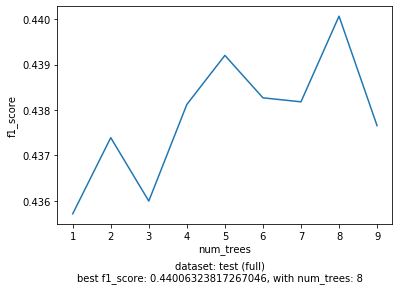

loading lex data for tweet
5 0.4535744931105487


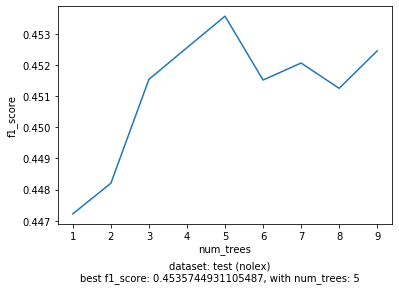

loading lex data for tweet
7 0.44645822416974


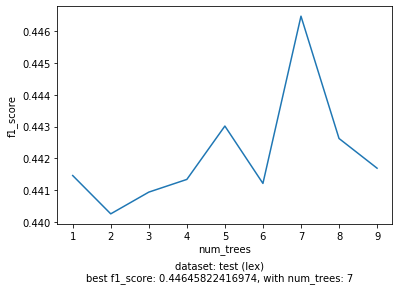

In [105]:
for dataset in datasets: 
    for key, feature_set in features.items(): 
        get_best_tree_num(dataset, feature_set, key, wc_mask, rel_mask, 150)

In [ ]:
all_results = []
importances = []

#for dataset in ["emotion"]: 
#    for key, feature_set in features.items(): 
#        results, importance = classify_with_rf(*load_lex_data(dataset, feature_set, wc_mask, rel_mask), num_trees)
#        all_results.append([dataset, key, *results])
#        importances.append(importance)
#    results, importance = classify_with_rf(*load_vector_data(dataset), num_trees)
#    all_results.append([dataset, "vec", *results])
#    importances.append(importance)

#for index, result in enumerate(all_results):
#    draw_confusion_matrix(*result)
#    print(importances[index])

loading lex data for norm_tweet
building rf model
... training model
... calcularing score
loading lex data for norm_tweet
building rf model
... training model
... calcularing score
loading lex data for norm_tweet
building rf model
... training model
... calcularing score
loading vector data for norm_tweet
... replacing placeholders
building rf model
... training model
... calcularing score
5
4


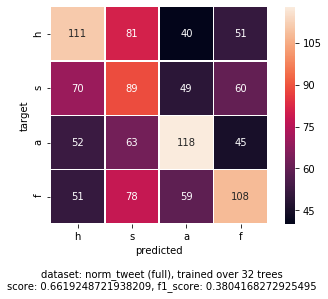

[0.30026381 0.08917358 0.18151828 0.12825161 0.09416585 0.
 0.09984096 0.10678592]


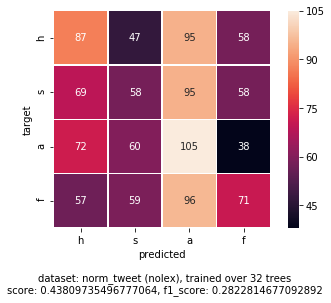

[0.32985324 0.18969612 0.25473585 0.22571478]


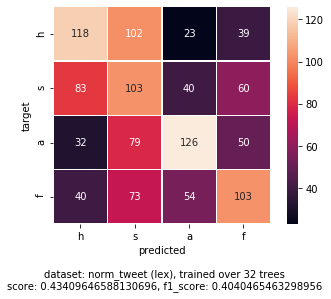

[0.20135603 0.         0.38629612 0.41234785]


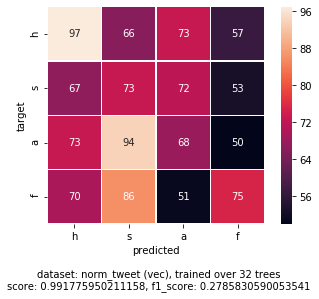

[0.03250196 0.02940771 0.03169461 0.0302037  0.03278067 0.02963582
 0.03214292 0.02964177 0.03183562 0.02930951 0.03101467 0.03109621
 0.02973081 0.03094487 0.03128072 0.03266016 0.03028877 0.03371662
 0.03316108 0.03037315 0.03256285 0.03101852 0.03065786 0.03091772
 0.02955587 0.03162531 0.03160481 0.02977621 0.03386894 0.03159888
 0.02997301 0.03341867]
